<h1><center>CSPB 3022 Project Part 3</center></h1><br>
<h3><center>Brendan Lancaster</center></h3>

<b>Project Topic + Data</b>

For my project, I'll be using [this](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download) dataset by Fedesoriano for predicting whether a person has or will have a stroke. This dataset was uploaded in 2021 and according to [this](https://www.kaggle.com/competitions/playground-series-s3e2/overview) competition using this dataset, this is supposedly synthetic data, meaning that the data of this set was generated from real world data. The author of this dataset said ["the [original] source of the data is confidential"](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/discussion/218525#1216522), so I assume this was done to protect the privacy of those included in the real data this dataset was based on. I'd love to get some experience in creating machine learning models, and this seems like a straightforward and personally interesting dataset to do so with (though I don't find it likely I'll be finding out anything groundbreaking with how limited the scope of this dataset is).

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


This is a classification task, determining a patient as either having had a stroke (1) or not having had a stroke (0) based on ten different attributes, such as their blood glucose levels and BMI. The data is conveniently already in tabulated form and has 5110 samples.

<b>Data Cleaning + EDA </b>

In [2]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

To clean the dataset, I'll need to deal with NaN BMI values. Since these make up almost 4% of the samples in the dataset, instead of deleting them, I'll be replacing them with the mean value of the other BMI values. This will effect the final results of my model by reducing the correlation BMI may have on classification by introducing meaningless values, but by using the mean value of BMI, I can minimize the damage it does to my data.

In [3]:
df['bmi'] = df['bmi'].fillna(df.loc[:, 'bmi'].mean())
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


I'll also be converting qualitative columns to binary values or splitting them into multiple columns for each unique value they can hold, then removing (arbitrarily chosen) baseline columns, eg one of the two residence types, one of the two "ever married" values, etc.

In [4]:
# Using pd.get_dummies to split classification columns into 0/1 columns for every possible value
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'Residence_type', \
                                 'work_type', 'smoking_status'])
# Removing irrelevant columns
df = df.drop(columns = ['ever_married_No', 'Residence_type_Rural'])
df = df.rename(columns={"ever_married_Yes" : "ever_married", \
                        "Residence_type_Urban" : "residence_type"})
df

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,residence_type,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.600000,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,51676,61.0,0,0,202.21,28.893237,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.500000,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.400000,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
4,1665,79.0,1,0,174.12,24.000000,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,28.893237,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
5106,44873,81.0,0,0,125.20,40.000000,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
5107,19723,35.0,0,0,82.99,30.600000,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
5108,37544,51.0,0,0,166.29,25.600000,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


<AxesSubplot:>

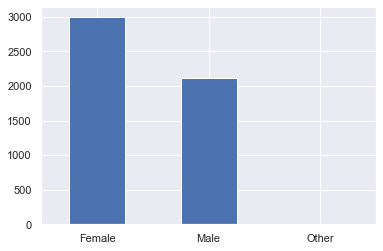

In [5]:
data = pd.DataFrame( \
                    dict(column=np.repeat(['Female', 'Male', 'Other'], \
                                          [str(len(df[df["gender_Female"]==1])), \
                                           str(len(df[df["gender_Male"]==1])), \
                                           str(len(df[df["gender_Other"]==1]))])))
data['column'].value_counts().plot.bar(rot=0)



<AxesSubplot:>

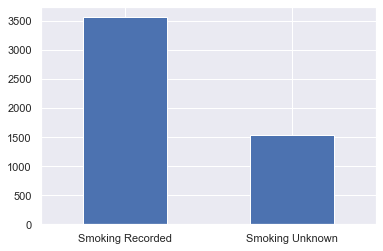

In [6]:
data = pd.DataFrame(dict(column=np.repeat(['Smoking Unknown', 'Smoking Recorded'], \
                                          [str(len(df[df["smoking_status_Unknown"]==1])), \
                                           str(len(df[df["smoking_status_Unknown"]==0]))])))
data['column'].value_counts().plot.bar(rot=0)

Because all but one entry in the data have a gender of "Other", I'll be removing that entry and column since there's not enough data for that column to be relevant. The other column that could cause issues, where smoking status is unknown, can be considered the "default" smoking status and can also be removed.

In [7]:
df = df[df.gender_Other != 1]
df = df.drop(columns = ['gender_Other', 'smoking_status_Unknown'])
# Now that gender is binary, only keep one column
df = df.drop(columns = ['gender_Female'])
# Rename categories for readability or to remove spaces
df = df.rename(columns={"gender_Male" : "gender", \
                        "smoking_status_formerly smoked" : "formerly_smoked", \
                        "smoking_status_never smoked" : "never_smoked", \
                        "smoking_status_smokes" : "smokes", \
                        "smoking_status_never smoked" : "never_smoked", \
                        "work_type_Self-employed" : "work_type_Selfemployed"})

As mentioned earlier, stroke patients make up only about 1/20th of the samples in the data. Now that the data has been thoroughly cleaned up, it can be resampled to fix its skewedness. In creating models later in this project and generating very low scores, I decided to fix this problem, and in doing so, made training models much more effective at learning from this dataset.

After SMOTE: 
4860 patients in the dataset had a stroke.
4860 patients in the dataset did not have a stroke.


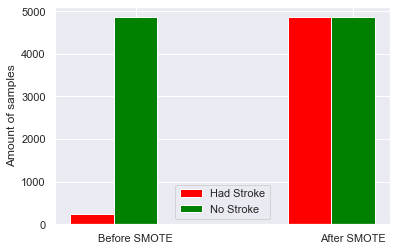

In [8]:
beforehadStroke = len(df.query('stroke == 1').index)
beforehadntStroke = len(df.query('stroke == 0').index)

import imblearn
from imblearn.over_sampling import SMOTE
x, y = df.drop(['stroke'], axis=1), df[['stroke']]
x, y = SMOTE(random_state = 1).fit_resample(x, y['stroke'].values.ravel())
y = pd.DataFrame({'stroke':y})
df = pd.concat([x,y],axis=1)
afterhadStroke = len(df.query('stroke == 1').index)
afterhadntStroke = len(df.query('stroke == 0').index)
print("After SMOTE: ")
print(str(afterhadStroke) + " patients in the dataset had a stroke.")
print(str(afterhadntStroke) + " patients in the dataset did not have a stroke.")

x = np.array([0,1])
width = 0.2

plt.bar(x-width, [beforehadStroke, beforehadntStroke], width, color='red')
plt.bar(x, [afterhadStroke, afterhadntStroke], width, color='green')
plt.xticks(x, ['Before SMOTE', "After SMOTE"])
plt.ylabel("Amount of samples")
plt.legend(["Had Stroke", "No Stroke"])
plt.show()

A correlation table can be used to more easily identify correlations between different variables within the dataset.

In [9]:
df_corr = df.corr(method='pearson')
df_corr = df_corr.loc[['stroke']]
df_corr = df_corr.transpose()
df_corr = df_corr.sort_values(by=['stroke'], ascending=False)
# Drop stroke vs stroke cell
df_corr = df_corr.iloc[1:]
df_corr

,stroke
age,0.591433
avg_glucose_level,0.291663
ever_married,0.159326
bmi,0.111329
id,0.004984
hypertension,-0.009530
heart_disease,-0.015562
work_type_Never_worked,-0.047629
formerly_smoked,-0.112026
work_type_Selfemployed,-0.115848


We should also drop non-statistically significant rows (those with a magnitude below 0.05) to remove variables that are likely to be due to chance.

In [10]:
df_corr = df_corr[abs(df_corr.stroke) >  0.05]
df_corr

,stroke
age,0.591433
avg_glucose_level,0.291663
ever_married,0.159326
bmi,0.111329
formerly_smoked,-0.112026
work_type_Selfemployed,-0.115848
work_type_Govt_job,-0.187504
smokes,-0.208535
residence_type,-0.215391
work_type_Private,-0.221681


Through this, we can tell that having a stroke is positively correlated with age, having heart disease, glucose levels, hypertension, having been married and having smoked in the past. Working with children is also correlated with a reduced chance of having a stroke. These are the variables I'll likely be using for my project (though I plan on using forward/backward selection of variables to focus on R values rather than just using the highest correlation variables).

In [11]:
import statsmodels.formula.api as smf
model_trn = smf.ols(formula= \
                    'stroke ~ age+heart_disease+avg_glucose_level+hypertension+ever_married+formerly_smoked+work_type_Selfemployed+work_type_children', \
                    data = df).fit()
model_trn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 stroke   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     1049.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:00:53   Log-Likelihood:                -4028.0
No. Observations:                9720   AIC:                             8074.
Df Residuals:                    9711   BIC:                             8139.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.4102      0.015    -27.457      0.000      -0.439      -0.381
age                        0.0173      0.000     71.888      0.000       0.017       0.018
heart_disease             -0.2585      0.018    -13.987      0.000      -0.295      -0.222
avg_glucose_level          0.0012   7.88e-05     14.981      0.000       0.001       0.001
hypertension              -0.1625      0.014    -12.011      0.000      -0.189      -0.136
ever_married              -0.1541      0.010    -15.917      0.000      -0.173      -0.135
formerly_smoked           -0.1806      0.011    -16.098      0.000      -0.203      -0.159
work_type_Selfemployed    -0.2658      0.012    -22.454      0.000      -0.289      -0.243
work_type_children         0.1871      0.019      9.954      0.000       0.150       0.224
==============================================================================
Omnibus:                      129.784   Durbin-Watson:                   0.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.563
Skew:                          -0.286   Prob(JB):                     6.03e-30
Kurtosis:                       2.923   Cond. No.                         823.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b>Model Approach</b>

<b>Deliverable 3</b>

Basic OLS regression using unfiltered access to the dataset without accounting for any colinearity has a terrible $R^{2}$ value, but this can be improved through several techniques. First, I'll choose which values to use for prediction.

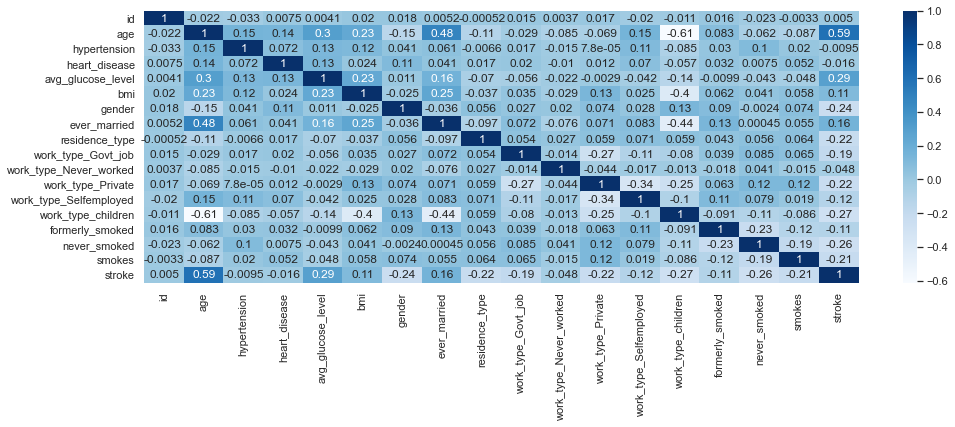

In [12]:
import statsmodels.formula.api as smf
# model_trn = smf.ols(formula= 'stroke ~ age*heart_disease*avg_glucose_level*hypertension*ever_married*formerly_smoked*work_type_Selfemployed*work_type_children', data = df).fit()
# model_trn.summary().pvalue
fig, ax = plt.subplots(figsize=(16,5))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax, cmap="Blues");

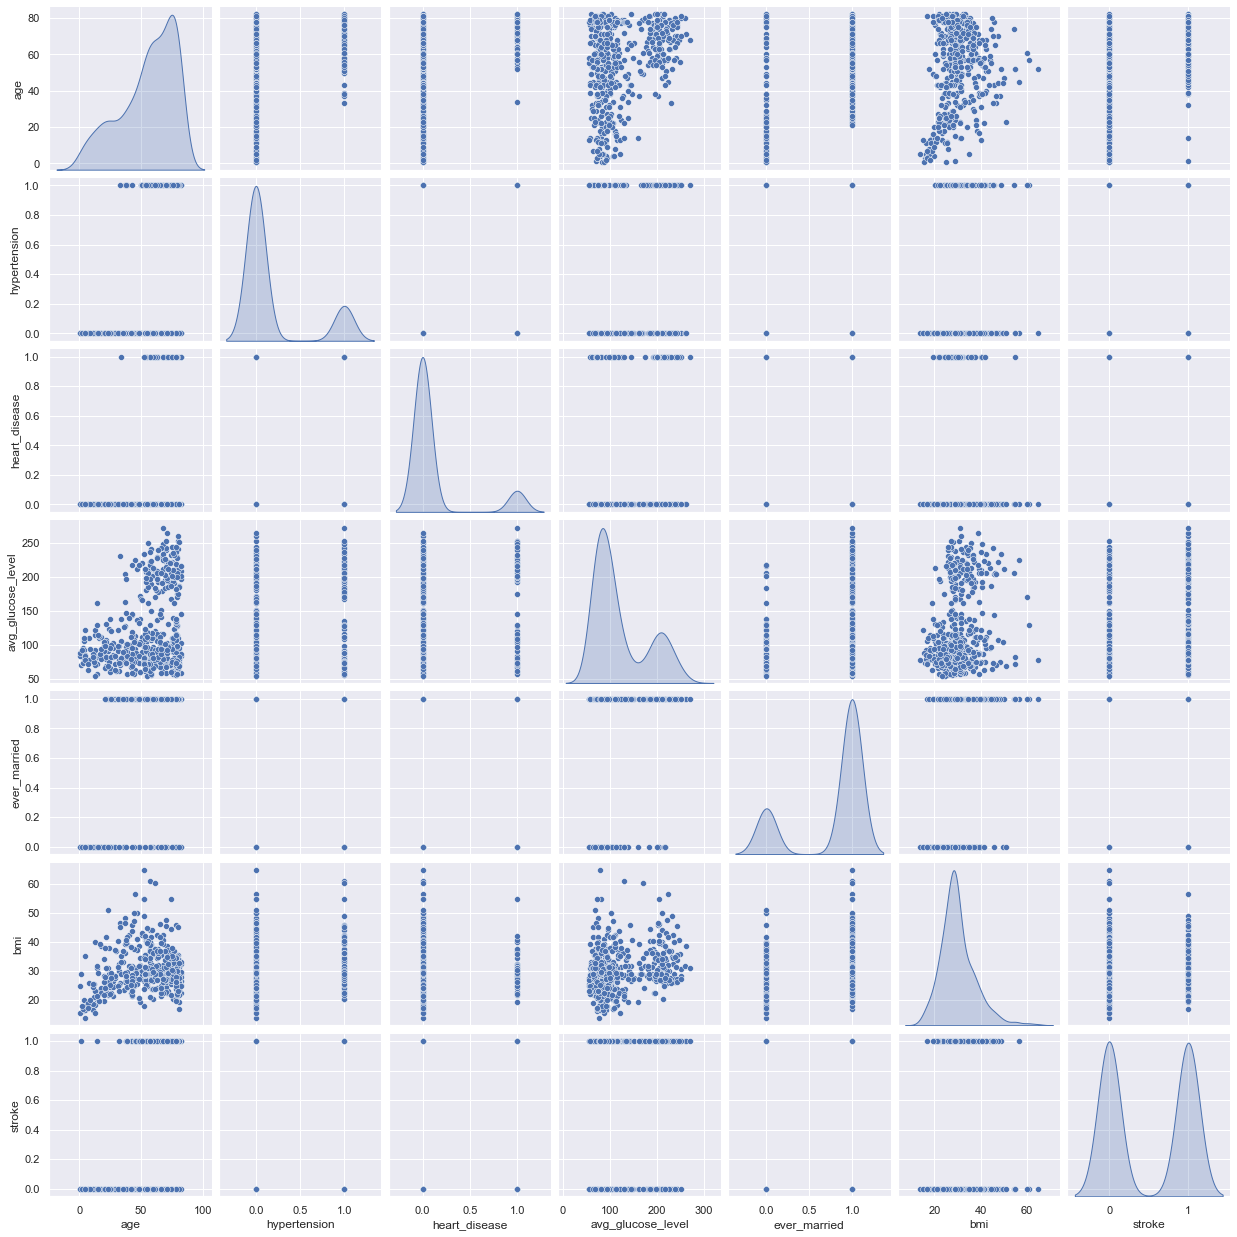

In [13]:
sns.pairplot(df[0:500][['age','hypertension','heart_disease','avg_glucose_level','ever_married', 'bmi', 'stroke']], diag_kind='kde');

Because many of these predictors are discrete- save for age, average glucose level, and bmi- the only possible way to use them in prediction is through a linear curve, and their viability can be determined through a heatmap. From this, it appears that hypertension, heart disease, and ever having been married are the best linear predictors for determining the chance of a stroke. Age and average glucose level show a clear correlation with stroke, though BMI is a bit more ambiguous. There appears to be collinearity between glucose level and age, glucose level and bmi and bmi and age, so I'll account for this in my model formula. As further verification, I'll be using VIF to confirm correlations I believe exist:

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[['age', 'avg_glucose_level', 'hypertension', 'ever_married', 'bmi']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                  for i in range(len(X.columns))]
print(vif_data)

             feature        VIF
0                age   9.954214
1  avg_glucose_level   7.276950
2       hypertension   1.124053
3       ever_married   4.719928
4                bmi  10.109481


Through VIF, age, average glucose level and BMI have very high values and likely correlate with one another.

<b>OLS Regression</b>

In [15]:
df = df.sample(frac=1)
training_size = int(df.shape[0] * 0.75)
train_df = df[0:training_size]
test_df = df[training_size:]
# Both glucose level:bmi and bmi:age had very high p-values, so I did not include them in the model
model_trn = smf.ols(formula= 'stroke ~ np.power(age, 4) + C(hypertension) + avg_glucose_level:np.power(age,2) + age:ever_married + age:bmi', \
                    data = df).fit()
model_trn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 stroke   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     1129.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:00:59   Log-Likelihood:                -4827.8
No. Observations:                9720   AIC:                             9668.
Df Residuals:                    9714   BIC:                             9711.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.0168      0.011     -1.554      0.120      -0.038       0.004
C(hypertension)[T.1]                  -0.2140      0.015    -14.609      0.000      -0.243      -0.185
np.power(age, 4)                    8.714e-09    5.1e-10     17.083      0.000    7.71e-09    9.71e-09
avg_glucose_level:np.power(age, 2)  3.103e-07   1.92e-08     16.176      0.000    2.73e-07    3.48e-07
age:ever_married                      -0.0017      0.000     -9.507      0.000      -0.002      -0.001
age:bmi                                0.0002   9.66e-06     20.708      0.000       0.000       0.000
==============================================================================
Omnibus:                      168.616   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.699
Skew:                          -0.282   Prob(JB):                     7.72e-36
Kurtosis:                       2.717   Cond. No.                     7.65e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.65e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import patsy
full_y,full_x = patsy.dmatrices("C(stroke,[[0],[1]]) ~ np.power(age, 4) + C(hypertension) + avg_glucose_level:np.power(age,2) + age:ever_married + age:bmi", data=df)
full_y = full_y.ravel()
x_train, x_test, y_train, y_test = train_test_split(full_x, full_y, test_size=0.4, random_state=0)
strokelr_mod = sklearn.linear_model.LogisticRegression().fit(x_train, y_train)

lr_prediction = strokelr_mod.predict(x_test)
lr_accuracy, lr_recall, lr_f1 = sklearn.metrics.accuracy_score(lr_prediction, y_test), sklearn.metrics.recall_score(lr_prediction, y_test), sklearn.metrics.f1_score(lr_prediction, y_test)
print('Accuracy for logistic regression was ', str(lr_accuracy))
print('Recall for logistic regression was ', str(lr_recall))
print('F1 score for logistic regression was ', str(lr_f1))

lr_cm = sklearn.metrics.confusion_matrix(y_test, lr_prediction)

Accuracy for logistic regression was  0.7680041152263375
Recall for logistic regression was  0.7707795560144554
F1 score for logistic regression was  0.7680041152263374


<b>KNN</b>

In [17]:
import sklearn.neighbors
strokenn_mod = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)

best_score = 0
best_accuracy_amount = 0
strokenn_mod = None
knn_prediction = None
for x in range(1,6):
    strokenn_mod = sklearn.neighbors.KNeighborsClassifier(n_neighbors=x).fit(x_train, y_train)
    prediction = strokenn_mod.predict(x_test)
    score = sklearn.metrics.accuracy_score(prediction, y_test)
    if (score > best_score):
        best_accuracy_amount = x
        best_score = score
        knn_prediction = prediction

knn_accuracy, knn_recall, knn_f1 = best_score, sklearn.metrics.recall_score(knn_prediction, y_test), sklearn.metrics.f1_score(knn_prediction, y_test)
print("Best prediction accuracy for KNN was found with " + str(x) + " neighbors, with an accuracy of " + str(best_score))
print('Recall for KNN was ', str(knn_recall))
print("F1 score for KNN was " + str(knn_f1))

knn_cm = sklearn.metrics.confusion_matrix(y_test, knn_prediction)

Best prediction accuracy for KNN was found with 5 neighbors, with an accuracy of 0.9068930041152263
Recall for KNN was  0.973198332340679
F1 score for KNN was 0.9002754820936638


<b>Random Forest</b>

In [18]:
import sklearn.ensemble
strokerfc_mod = sklearn.ensemble.RandomForestClassifier(n_estimators=300, random_state=0, max_depth=12).fit(x_train, y_train)
rfc_prediction = strokerfc_mod.predict(x_test)

rfc_accuracy, rfc_recall, rfc_f1 = sklearn.metrics.accuracy_score(rfc_prediction, y_test), sklearn.metrics.recall_score(rfc_prediction, y_test), sklearn.metrics.f1_score(rfc_prediction, y_test)
print("Best prediction accuracy for RFC was " + str(rfc_accuracy))
print('Recall for RFC was ' + str(rfc_recall))
print('F1 score for RFC was ' + str(rfc_f1))

rfc_cm = sklearn.metrics.confusion_matrix(y_test, rfc_prediction)

Best prediction accuracy for RFC was 0.8575102880658436
Recall for RFC was 0.8199725148877691
F1 score for RFC was 0.8659893565553943


<b>Results, Analysis and Discussion</b>

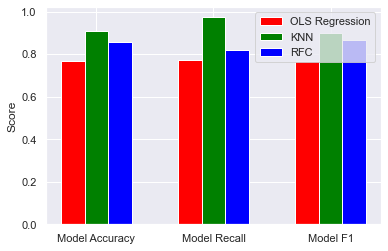

In [19]:
x = np.array([0,1,2])
y1 = [lr_accuracy, lr_recall, lr_f1]
y2 = [lr_accuracy, lr_recall, lr_f1]
width = 0.2

plt.bar(x-width, [lr_accuracy, lr_recall, lr_f1], width, color='red')
plt.bar(x, [knn_accuracy, knn_recall, knn_f1], width, color='green')
plt.bar(x+width, [rfc_accuracy, rfc_recall, rfc_f1], width, color='blue')
plt.xticks(x, ['Model Accuracy', "Model Recall", "Model F1"])
plt.ylabel("Score")
plt.legend(["OLS Regression", "KNN", "RFC"])
plt.show()

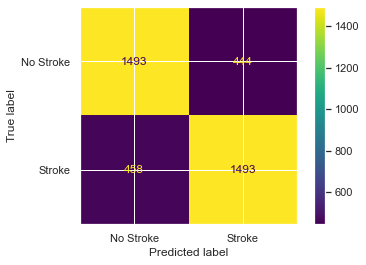

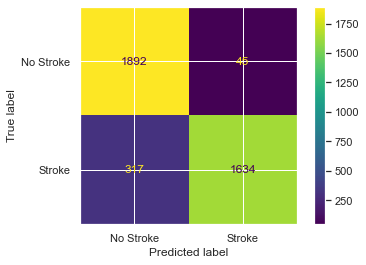

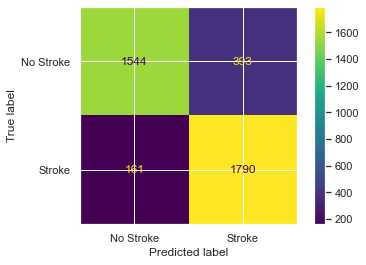

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = ["No Stroke", "Stroke"])
display.plot()
plt.show()
display = ConfusionMatrixDisplay(confusion_matrix = knn_cm, display_labels = ["No Stroke", "Stroke"])
display.plot()
plt.show()
display = ConfusionMatrixDisplay(confusion_matrix = rfc_cm, display_labels = ["No Stroke", "Stroke"])
display.plot()
plt.show()

As a note, Random Forest Classification or RFC, was not a model we went over in class. It works by creating several decision trees, which are where depending on the value of a predictor a different path will be taken, then outputting a classification based on whichever output received the most votes. Through testing different parameters, 300 different trees with a depth of 12 decisions gave the best scores for this dataset.

I chose accuracy, recall and F1 (accuracy and recall combined) to determine how well each model performed. KNN scored the highest of all models, with RFC coming in second and OLS third. I feel this may be because of how much noise there was in the data- despite some correlation, much of the data didn't follow an exact line and was extremely noisy.

By far the largest improvement in my models came from dealing with the underrepresentation of stroke cases- beginning with 5%, and after using SMOTE, 50%- which led to the model recalls and F1 scores to skyrocket. I think that if I had more time, I'd like how well these would perform if I hadn't also modified the testing set- SMOTE's mechanics went a bit over my head after trying to research it, and I feel it may have somehow enforced patterns it may have recognized to help artificially make my model perform better.


I do feel like I may have been able to find a better solution towards fixing NaN BMI values had I spent more time with it. Before deskewing my samples, BMI did not correlate anywhere near as well as the other parameters I used and likely still causes some damage to my models, especially to RFC, which as far as I understand, essentially can't use BMI in its predictions since it's trying to use cutoff values for a field with lots of inaccurate, homogenized values. RFC may have performed better had I just excluded BMI from its parameters.

<b>References</b>

- Dataset: <br> Fedesoriano. (2021, January 26). Stroke prediction dataset. Kaggle. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/discussion/218525#1216522 
- “Detecting Multicollinearity with VIF - Python.” GeeksforGeeks, 10 Jan. 2023, www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/. 